In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

# Load the FashionMNIST dataset
fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


100%|██████████| 26421880/26421880 [00:11<00:00, 2315119.01it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167878.41it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1325777.76it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19024032.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


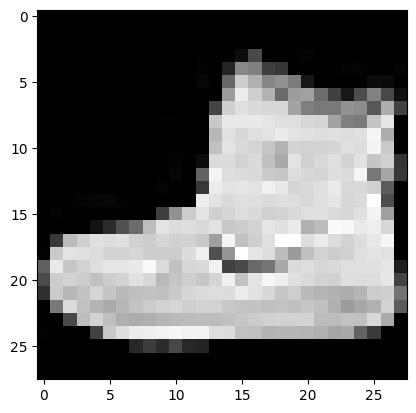

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 6, 4, 5, 2, 4, 8, 0, 0, 6, 9, 1, 7, 0, 9, 7, 3, 3, 7, 8, 5, 0, 0, 3,
        2, 7, 6, 0, 1, 8, 6, 5, 8, 9, 2, 7, 9, 3, 8, 8, 5, 2, 4, 5, 8, 9, 1, 6,
        7, 6, 4, 3, 5, 0, 3, 4, 6, 7, 3, 6, 4, 4, 9, 9, 2, 7, 6, 8, 1, 3, 7, 2,
        1, 3, 3, 4, 3, 0, 5, 5, 1, 7, 4, 4, 1, 1, 6, 9, 6, 9, 7, 5, 8, 8, 6, 5,
        4, 3, 5, 3])


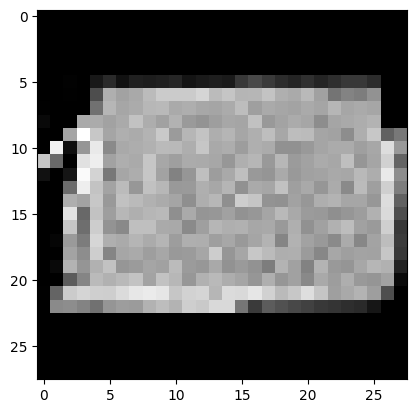

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# CUDA configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
device

device(type='cuda')

In [8]:
image_size = 784
hidden_size = 256

In [9]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
D.to(device);

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

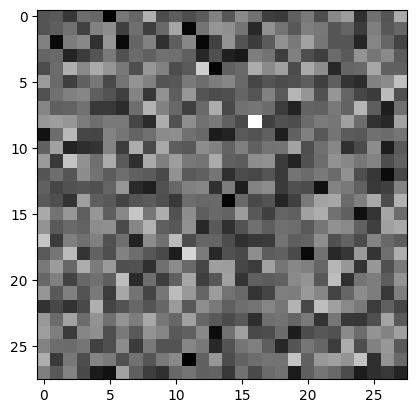

In [14]:
plt.imshow(gen_imgs[0], cmap='gray');

In [15]:
G.to(device);

In [16]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [17]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [18]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [19]:
def train_generator():
    # Generate fake images & calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backpropagation and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Model Training

In [20]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

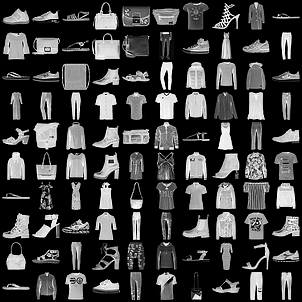

In [21]:
from IPython.display import Image
from torchvision.utils import save_image

# Saving real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


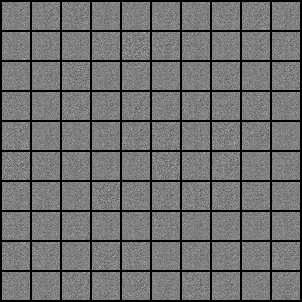

In [22]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [23]:
%%time

num_epochs = 250
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Loading the  batch & transforming  into vectors
        images = images.reshape(batch_size, -1).to(device)

        # Training the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # save images
    save_fake_images(epoch+1)

Epoch [0/250], Step [200/600], d_loss: 0.0254, g_loss: 0.8610, D(x): 0.95, D(G(z)): 0.10
Epoch [0/250], Step [400/600], d_loss: 0.0201, g_loss: 0.9343, D(x): 0.98, D(G(z)): 0.06
Epoch [0/250], Step [600/600], d_loss: 0.0125, g_loss: 0.9523, D(x): 0.96, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/250], Step [200/600], d_loss: 0.0056, g_loss: 0.9656, D(x): 0.98, D(G(z)): 0.03
Epoch [1/250], Step [400/600], d_loss: 0.0073, g_loss: 0.9304, D(x): 0.98, D(G(z)): 0.05
Epoch [1/250], Step [600/600], d_loss: 0.0021, g_loss: 0.9482, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/250], Step [200/600], d_loss: 0.0001, g_loss: 0.9938, D(x): 1.00, D(G(z)): 0.01
Epoch [2/250], Step [400/600], d_loss: 0.0011, g_loss: 0.9795, D(x): 1.00, D(G(z)): 0.02
Epoch [2/250], Step [600/600], d_loss: 0.0061, g_loss: 0.9147, D(x): 0.99, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/250], Step [200/600], d_loss: 0.0348, g_loss: 0.9778, D(x): 0.96, D(G(z)): 0.04
Epoch [3/250], Step [400/6

In [24]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

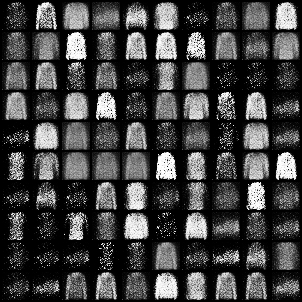

In [25]:
Image('./samples/fake_images-0010.png')

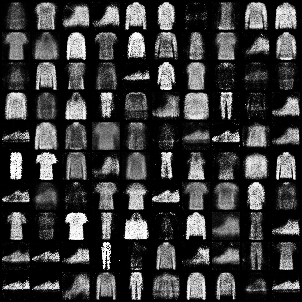

In [26]:
Image('./samples/fake_images-0050.png')

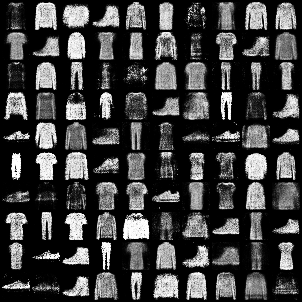

In [27]:
Image('./samples/fake_images-0150.png')

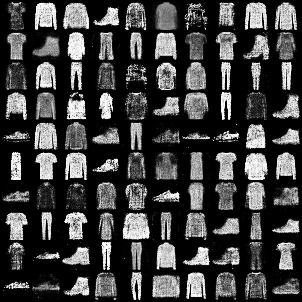

In [28]:
Image('./samples/fake_images-0250.png')

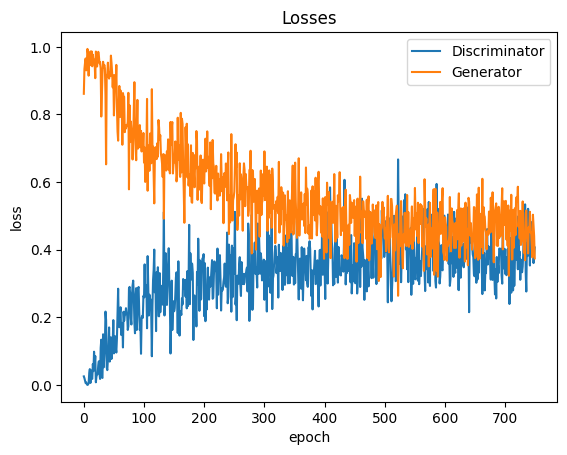

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

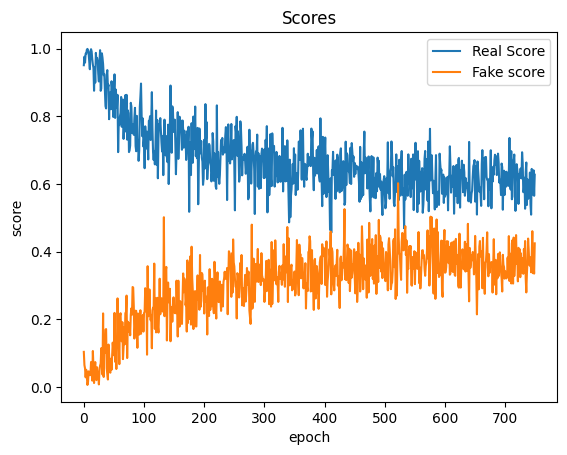

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

LSGAN uses a least squares loss function that helps the discriminator accurately classify both real and generated images. This approach is thought to provide more stable training and improve the quality of generated images.
- real images = 1 and generated images = 0

When applied to the FashionMNIST dataset, LSGANs tend to produce images of higher quality compared to traditional GANs. The generated images are usually more realistic and consistent in quality, thanks to the more stable training dynamics enabled by the least squares loss.


Discriminator Loss and Generator loss After 250 epochs in GAN.

- d_loss: 1.1161, g_loss: 0.9667

Discriminator Loss and Generator Loss After 250 epochs in LSGAN.

- d_loss: 0.4066, g_loss: 0.3743